# Hourly Energy Consumption

The open data set we're using for this demonstration is the hourly power consumption data comes from PJM's website and are in megawatts (MW).

#### Data-set Files

###### (https://github.com/azeem2020/Energy-Consumption-Predictions-Analysis)

### Overview
This is divided into five parts; they are:
<ul>
<li>Problem Description</li>
<li>Load and Prepare Dataset</li>
<li>Model Evaluation</li>
<li>Correlation Analysis</li>
<li>Develop an Regression Model</li>
</ul>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import os

In [2]:
#!pip install xgboost

In [3]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings  
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

#### Data Set
We will use hourly power consumption data from <a href='https://www.pjm.com/'>PJM</a> East, it contain data from 2002-2018 for the entire east region.

In [4]:
os.getcwd() # Get current work directory 

'C:\\Users\\azeem\\Documents\\MIE_2.02_GeoInfo_WS2019\\gi0301_ALS_DTM_NRW'

In [5]:
os.chdir('C:\\Users\\azeem\\Documents\\GitHub Repositories\\Energy-Consumption-Predictions-Analysis')  # Provide the new path here
os.getcwd()

'C:\\Users\\azeem\\Documents\\GitHub Repositories\\Energy-Consumption-Predictions-Analysis'

In [6]:
pjme_df = pd.read_csv('data/PJM/hourly-energy-consumption/PJME_hourly.csv', parse_dates=[0], index_col=[0])
pjme_df = pjme_df.loc[~pjme_df.index.duplicated(keep='first')].sort_index().dropna()
pjme_df.head() # top 5 rows

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


##### Dimensionality of the DataFrame
Return a tuple representing the dimensionality of the DataFrame.

In [7]:
pjme_df.shape 

(145362, 1)

##### Generate summarize descriptive Statistics
###### pandas.DataFrame.describe
Generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding <i>NaN</i> values.

In [8]:
pjme_df.describe()

,PJME_MW
count,145362.000000
mean,32080.505139
std,6463.874131
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


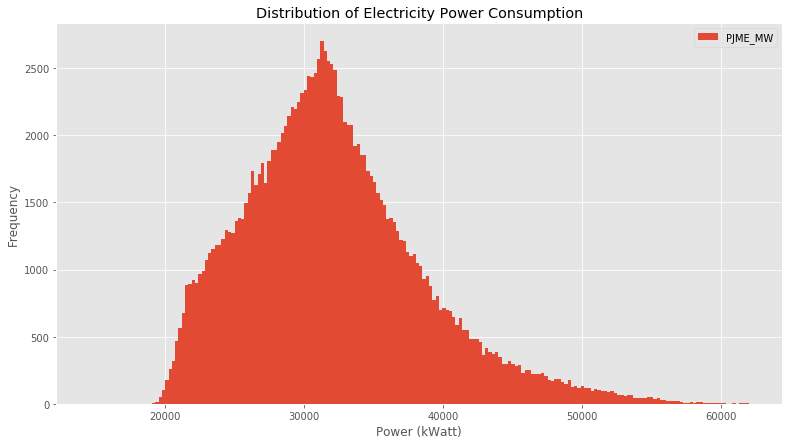

In [9]:
gp = pjme_df.plot.hist(figsize=(13, 7), bins=200, title='Distribution of Electricity Power Consumption')
plt.xlabel('Power (kWatt)')
plt.show()

##### View City Aattributes CSV files

In [10]:
city_attributes = pd.read_csv('data/PJM/historical-hourly-weather-data/humidity.csv', nrows= 0)
city_attributes

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem


#### Weather Data

In [11]:
city = 'New York'
humidity = pd.read_csv('data/PJM/historical-hourly-weather-data/humidity.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('humidity')
pressure = pd.read_csv('data/PJM/historical-hourly-weather-data/pressure.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('pressure')
temperature = pd.read_csv('data/PJM/historical-hourly-weather-data/temperature.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('temperature')
wind_direction = pd.read_csv('data/PJM/historical-hourly-weather-data/wind_direction.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('wind_direction')
wind_speed = pd.read_csv('data/PJM/historical-hourly-weather-data/wind_speed.csv', parse_dates=[0], index_col=[0])[city].dropna().rename('wind_speed')

In [12]:
humidity.head()

datetime
2012-10-01 13:00:00    58.0
2012-10-01 14:00:00    57.0
2012-10-01 15:00:00    57.0
2012-10-01 16:00:00    57.0
2012-10-01 17:00:00    57.0
Name: humidity, dtype: float64

In [13]:
temperature.head()

datetime
2012-10-01 13:00:00    288.220000
2012-10-01 14:00:00    288.247676
2012-10-01 15:00:00    288.326940
2012-10-01 16:00:00    288.406203
2012-10-01 17:00:00    288.485467
Name: temperature, dtype: float64

#### Combine Power and weather data

In [14]:
weather_df = pd.concat([temperature, humidity, pressure, wind_direction, wind_speed], axis=1).sort_index()
weather_df = weather_df.loc[~weather_df.index.duplicated(keep='first')].sort_index().dropna()
weather_df = weather_df.assign(pressure_log = weather_df.pressure.apply(np.log))
weather_df.head()

,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log
datetime,,,,,,
2012-10-01 13:00:00,288.220000,58.0,1012.0,260.0,7.0,6.919684
2012-10-01 14:00:00,288.247676,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 15:00:00,288.326940,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 16:00:00,288.406203,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 17:00:00,288.485467,57.0,1012.0,261.0,6.0,6.919684


In [15]:
comb_df = pd.concat([pjme_df.loc[weather_df.index[0]:weather_df.index[-1]], weather_df], axis=1).sort_index().dropna()

comb_df.head()

,PJME_MW,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log
2012-10-01 13:00:00,30231.0,288.220000,58.0,1012.0,260.0,7.0,6.919684
2012-10-01 14:00:00,30461.0,288.247676,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 15:00:00,30553.0,288.326940,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 16:00:00,30562.0,288.406203,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 17:00:00,30640.0,288.485467,57.0,1012.0,261.0,6.0,6.919684


In [16]:
comb_df.tail()

,PJME_MW,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log
2017-10-27 20:00:00,29047.0,289.98,36.0,1019.0,0.0,3.0,6.926577
2017-10-27 21:00:00,28316.0,289.48,38.0,1019.0,0.0,1.0,6.926577
2017-10-27 22:00:00,27246.0,287.92,54.0,1019.0,196.0,2.0,6.926577
2017-10-27 23:00:00,25616.0,285.83,62.0,1020.0,171.0,3.0,6.927558
2017-10-28 00:00:00,23912.0,284.98,58.0,1020.0,0.0,2.0,6.927558


#### Power and weather data visualization

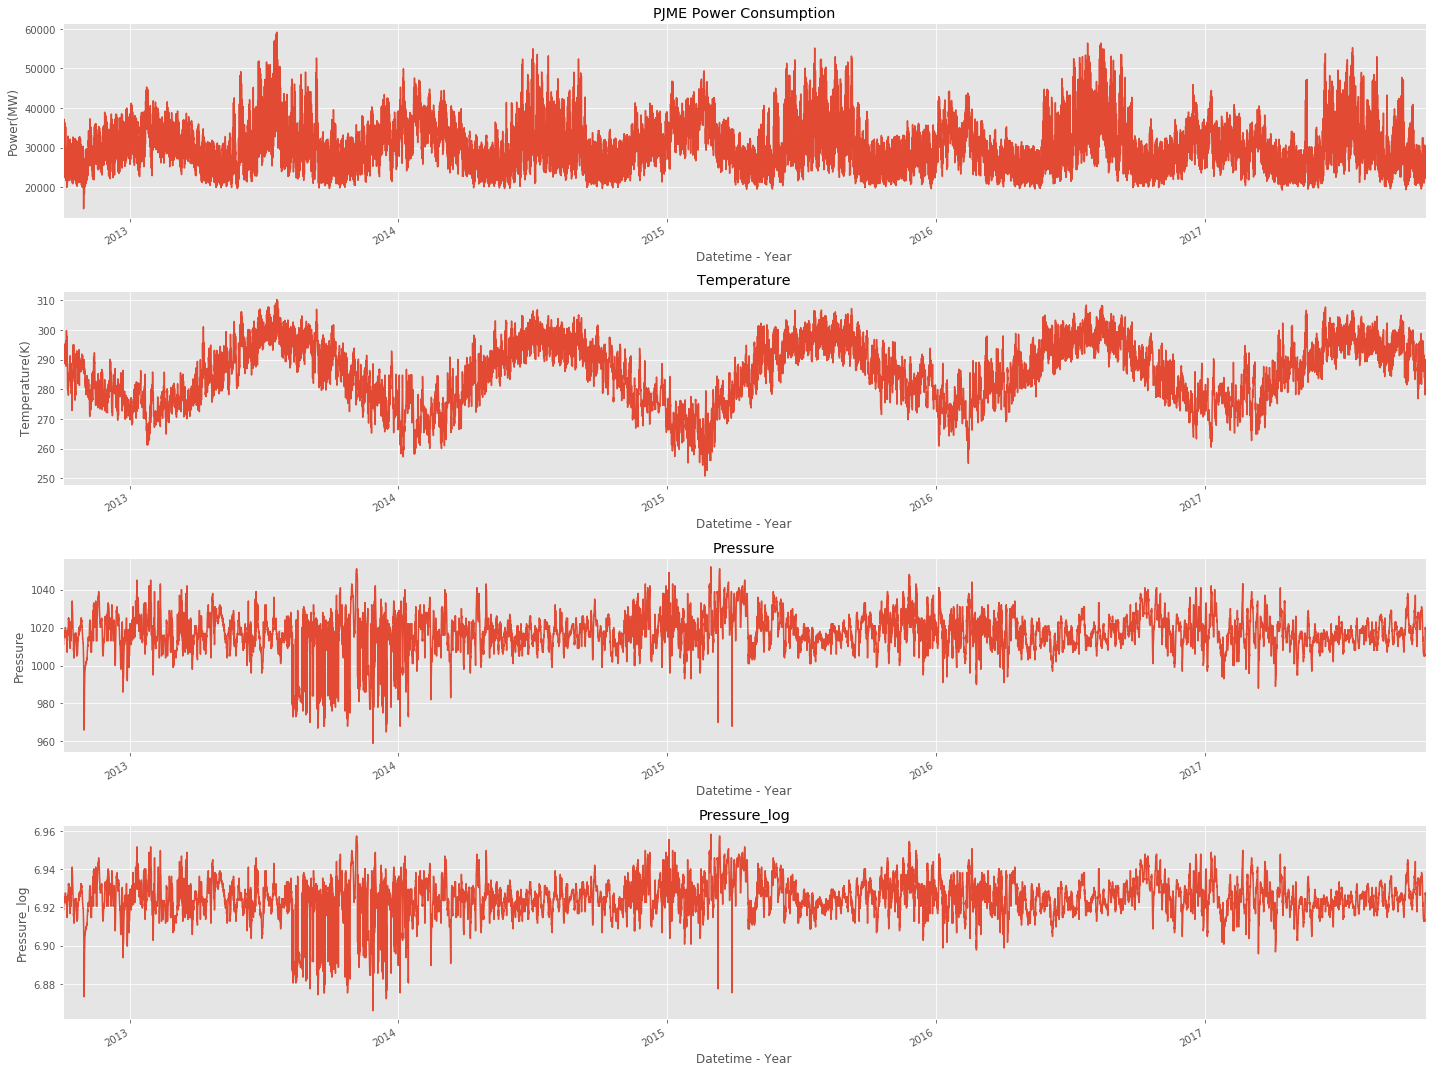

<Figure size 432x288 with 0 Axes>

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,15))
axes[0].set_title('PJME Power Consumption')
axes[0].set_ylabel('Power(MW)')
axes[0].set_xlabel('Datetime - Year')
comb_df.PJME_MW.plot(ax=axes[0])

axes[1].set_title('Temperature')
axes[1].set_ylabel('Temperature(K)')
axes[1].set_xlabel('Datetime - Year')
comb_df.temperature.plot(ax=axes[1])

axes[2].set_title('Pressure')
axes[2].set_ylabel('Pressure')
axes[2].set_xlabel('Datetime - Year')
comb_df.pressure.plot(ax=axes[2])

axes[3].set_title('Pressure_log')
axes[3].set_ylabel('Pressure_log')
axes[3].set_xlabel('Datetime - Year')
comb_df.pressure_log.plot(ax=axes[3])

plt.tight_layout()
plt.show()
fig = plt.figure()
plt.savefig("Image.png") # save as png

#### Time series features

In [18]:
final_df = (comb_df.assign( day_of_week = comb_df.index.dayofweek
                            ,year = comb_df.index.year
                            ,month = comb_df.index.month
                            ,day = comb_df.index.day
                            ,day_of_year = comb_df.index.dayofyear

                            ,week = comb_df.index.week
                            ,week_day = comb_df.index.weekday_name 
                            ,quarter = comb_df.index.quarter
                            ,hour = comb_df.index.hour
                            ,hour_x = np.sin(2.*np.pi*comb_df.index.hour/24.)
                            ,hour_y = np.cos(2*np.pi*comb_df.index.hour/24.)
                            ,day_of_year_x = np.sin(2.*np.pi*comb_df.index.dayofyear/365.)
                            ,day_of_year_y = np.cos(2.*np.pi*comb_df.index.dayofyear/365.)
                            )
            )

# df['hourfloat']=df.hour+df.minute/60.0
# df['x']=np.sin(2.*np.pi*df.hourfloat/24.)
# df['y']=np.cos(2.*np.pi*df.hourfloat/24.)

In [19]:
final_df.head()

,PJME_MW,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
2012-10-01 13:00:00,30231.0,288.220000,58.0,1012.0,260.0,7.0,6.919684,0,2012,10,1,275,40,Monday,4,13,-0.258819,-0.965926,-0.999769,0.021516
2012-10-01 14:00:00,30461.0,288.247676,57.0,1012.0,260.0,7.0,6.919684,0,2012,10,1,275,40,Monday,4,14,-0.500000,-0.866025,-0.999769,0.021516
2012-10-01 15:00:00,30553.0,288.326940,57.0,1012.0,260.0,7.0,6.919684,0,2012,10,1,275,40,Monday,4,15,-0.707107,-0.707107,-0.999769,0.021516
2012-10-01 16:00:00,30562.0,288.406203,57.0,1012.0,260.0,7.0,6.919684,0,2012,10,1,275,40,Monday,4,16,-0.866025,-0.500000,-0.999769,0.021516
2012-10-01 17:00:00,30640.0,288.485467,57.0,1012.0,261.0,6.0,6.919684,0,2012,10,1,275,40,Monday,4,17,-0.965926,-0.258819,-0.999769,0.021516


#### Features correlation heatmap

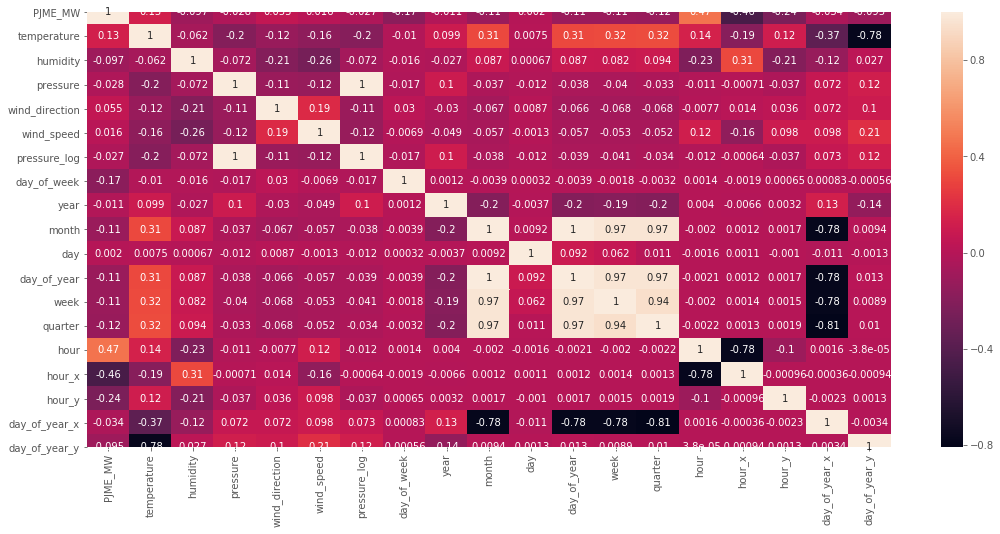

In [20]:
fig, ax = plt.subplots(figsize = (18,8))
corr = final_df.corr()
ax = sns.heatmap(corr, annot=True,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values)
plt.show()

#final_df.corr().round(2)


<b>Power consumption</b> is highly correlated to the <b>hour</b>.

### Regression Models

In [21]:
final_df.head()

,PJME_MW,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
2012-10-01 13:00:00,30231.0,288.220000,58.0,1012.0,260.0,7.0,6.919684,0,2012,10,1,275,40,Monday,4,13,-0.258819,-0.965926,-0.999769,0.021516
2012-10-01 14:00:00,30461.0,288.247676,57.0,1012.0,260.0,7.0,6.919684,0,2012,10,1,275,40,Monday,4,14,-0.500000,-0.866025,-0.999769,0.021516
2012-10-01 15:00:00,30553.0,288.326940,57.0,1012.0,260.0,7.0,6.919684,0,2012,10,1,275,40,Monday,4,15,-0.707107,-0.707107,-0.999769,0.021516
2012-10-01 16:00:00,30562.0,288.406203,57.0,1012.0,260.0,7.0,6.919684,0,2012,10,1,275,40,Monday,4,16,-0.866025,-0.500000,-0.999769,0.021516
2012-10-01 17:00:00,30640.0,288.485467,57.0,1012.0,261.0,6.0,6.919684,0,2012,10,1,275,40,Monday,4,17,-0.965926,-0.258819,-0.999769,0.021516


#### Lagging features

In [22]:
# Build lagged weather predictors.
# lagged_df = comb_df.loc[comb_df.index.min().ceil('D'):].copy()
lagged_df = final_df.copy()

# Next day's load values.
lagged_df['load_tomorrow'] = lagged_df['PJME_MW'].shift(-24)    

for day in range(8):
    lagged_df['temperature_d' + str(day)] = lagged_df.temperature.shift(24*day)
    lagged_df['wind_speed_d' + str(day)] = lagged_df.wind_speed.shift(24*day)
    lagged_df['humidity_d' + str(day)] = lagged_df.humidity.shift(24*day)
    lagged_df['pressure_log_d' + str(day)] = lagged_df.pressure_log.shift(24*day)

    
    
    lagged_df['load_d' + str(day)] = lagged_df.PJME_MW.shift(24*day)

     
lagged_df = lagged_df.dropna()
    

lagged_df = lagged_df.drop(columns=['temperature', 'wind_speed', 'humidity', 'pressure', 'wind_direction', 'week_day','PJME_MW'])
# lagged_df.iloc[50:80]

In [23]:
lagged_df.tail(5)

,pressure_log,day_of_week,year,month,day,day_of_year,week,quarter,hour,hour_x,...,temperature_d6,wind_speed_d6,humidity_d6,pressure_log_d6,load_d6,temperature_d7,wind_speed_d7,humidity_d7,pressure_log_d7,load_d7
2017-10-26 20:00:00,6.913737,3,2017,10,26,299,43,4,20,-0.866025,...,296.30,2.0,18.0,6.927558,29149.0,295.24,1.0,37.0,6.927558,30438.0
2017-10-26 21:00:00,6.914731,3,2017,10,26,299,43,4,21,-0.707107,...,295.82,6.0,27.0,6.926577,28160.0,294.65,4.0,35.0,6.927558,29539.0
2017-10-26 22:00:00,6.915723,3,2017,10,26,299,43,4,22,-0.500000,...,294.14,2.0,24.0,6.928538,26854.0,292.48,2.0,40.0,6.926577,27962.0
2017-10-26 23:00:00,6.916715,3,2017,10,26,299,43,4,23,-0.258819,...,292.23,2.0,30.0,6.928538,25115.0,290.45,2.0,42.0,6.927558,25731.0
2017-10-27 00:00:00,6.918695,4,2017,10,27,300,43,4,0,0.000000,...,289.51,2.0,30.0,6.929517,23384.0,289.67,2.0,42.0,6.927558,23737.0


In [24]:
X = lagged_df.drop(columns=['load_tomorrow'])
y = lagged_df['load_tomorrow']

In [25]:
X.shape

(43411, 53)

In [26]:
y.shape

(43411,)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [28]:
def plot_prediction(actual, prediction, start_date, end_date, title, prediction_label):
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, prediction, label=prediction_label)
    plt.ylabel('Power(MW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.xlim(left= start_date, right=end_date)
    plt.show()
    
def subplot_prediction(actual, prediction,prediction_label):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)
    axes[0].set_title('Actual vs Prediction - One day')
    axes[0].set_ylabel('Power(MW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[0])
    axes[0].set_xlim(left=con_df.index[-24*1] , right=con_df.index[-1])
    
    axes[1].set_title('Actual vs Prediction - One week')
    axes[1].set_ylabel('Power(MW)')
    axes[1].set_xlabel('Datetime')
    con_df.plot(ax=axes[1])
    axes[1].set_xlim(left=actual.index[-24*7] , right=actual.index[-1])
    
    axes[2].set_title('Actual vs Prediction - One month')
    axes[2].set_ylabel('Power(MW)')
    axes[2].set_xlabel('Datetime')
    con_df.plot(ax=axes[2])
    axes[2].set_xlim(left=actual.index[-24*7*4] , right=actual.index[-1])
    
    plt.tight_layout()
    plt.show()
    
def plot_feature_importances( clf, X_train, y_train=None
                             ,top_n=10, figsize=(10,18), print_table=False, title="Feature Importances"):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

In [29]:
reg = xgb.XGBRegressor()

In [30]:
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))
print(scores)

[16:19:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:19:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 0.84 (+/- 0.05)
[0.75221628 0.84069014 0.86248085 0.88725891 0.83784977]


In [31]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)

[16:20:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


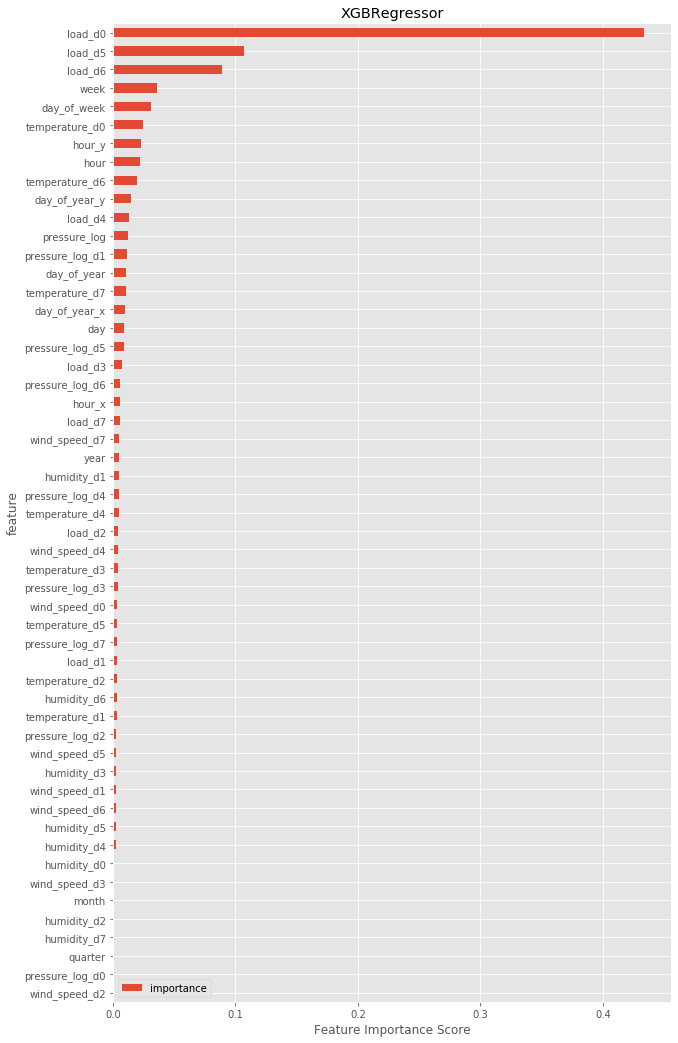

Top 53 features in descending order of importance


,importance
feature,
load_d0,0.433745
load_d5,0.106886
load_d6,0.089060
week,0.035739
day_of_week,0.031219
temperature_d0,0.024572
hour_y,0.022643
hour,0.021970
temperature_d6,0.019842


In [32]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__, print_table=True)

In [33]:
comb_df.head()

,PJME_MW,temperature,humidity,pressure,wind_direction,wind_speed,pressure_log
2012-10-01 13:00:00,30231.0,288.220000,58.0,1012.0,260.0,7.0,6.919684
2012-10-01 14:00:00,30461.0,288.247676,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 15:00:00,30553.0,288.326940,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 16:00:00,30562.0,288.406203,57.0,1012.0,260.0,7.0,6.919684
2012-10-01 17:00:00,30640.0,288.485467,57.0,1012.0,261.0,6.0,6.919684


In [34]:
def get_features(date, comb_df):
    features = comb_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                
                                ))
    
    for day in range(8):
        features['temperature_d' + str(day)] = comb_df.temperature.shift(24*day)
        features['wind_speed_d' + str(day)] = comb_df.wind_speed.shift(24*day)
        features['humidity_d' + str(day)] = comb_df.humidity.shift(24*day)
        features['pressure_log_d' + str(day)] = comb_df.pressure_log.shift(24*day)



        features['load_d' + str(day)] = comb_df.PJME_MW.shift(24*day)

    features = features.dropna()
    
    features = features.drop(columns=['temperature', 'wind_speed', 'humidity', 'pressure', 'wind_direction','PJME_MW'])

    return features

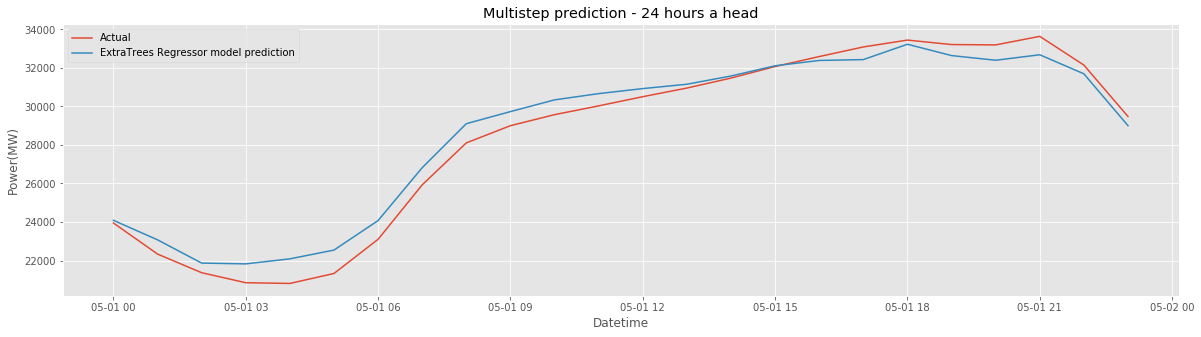

In [35]:
date = '2017-05-01'


prediction = reg.predict(get_features(date, comb_df))
idx = comb_df.PJME_MW.loc[date].index 


def plot_prediction_multistep(actual, prediction, start_date, title, prediction_label):
    date_rng = pd.date_range(start=start_date, periods=24, freq='H')
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, prediction, label=prediction_label)
    plt.ylabel('Power(MW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.show()
    
plot_prediction_multistep(actual=comb_df.PJME_MW.loc[date],prediction=prediction, start_date=date, title='Multistep prediction - 24 hours a head',
                prediction_label='ExtraTrees Regressor model prediction')    
    
    

# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
    
# con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)
# axes[0].set_title('Actual vs Prediction - One day')
# axes[0].set_ylabel('Power(MW)')
# axes[0].set_xlabel('Datetime')
# con_df.plot(ax=axes[0])
# axes[0].set_xlim(left=con_df.index[-24*1] , right=con_df.index[-1])

# axes[1].set_title('Actual vs Prediction - One week')
# axes[1].set_ylabel('Power(MW)')
# axes[1].set_xlabel('Datetime')
# con_df.plot(ax=axes[1])
# axes[1].set_xlim(left=actual.index[-24*7] , right=actual.index[-1])

# axes[2].set_title('Actual vs Prediction - One month')
# axes[2].set_ylabel('Power(MW)')
# axes[2].set_xlabel('Datetime')
# con_df.plot(ax=axes[2])
# axes[2].set_xlim(left=actual.index[-24*7*4] , right=actual.index[-1])

# plt.tight_layout()
# plt.show()

### Regression Models

In [36]:
X = final_df.drop(columns = ['PJME_MW','week_day'])
y = final_df['PJME_MW']

In [37]:
X.shape

(43603, 18)

In [38]:
y.shape

(43603,)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

### XGB Model

In [40]:
reg = xgb.XGBRegressor()

In [41]:
tscv = TimeSeriesSplit(n_splits=10)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))
print(scores)

[16:20:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:20:30] WARNI

In [42]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)

[16:20:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


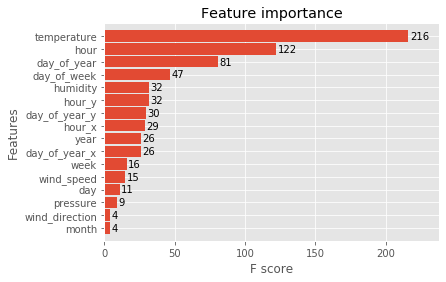

In [43]:
_ = plot_importance(reg, height=0.9)

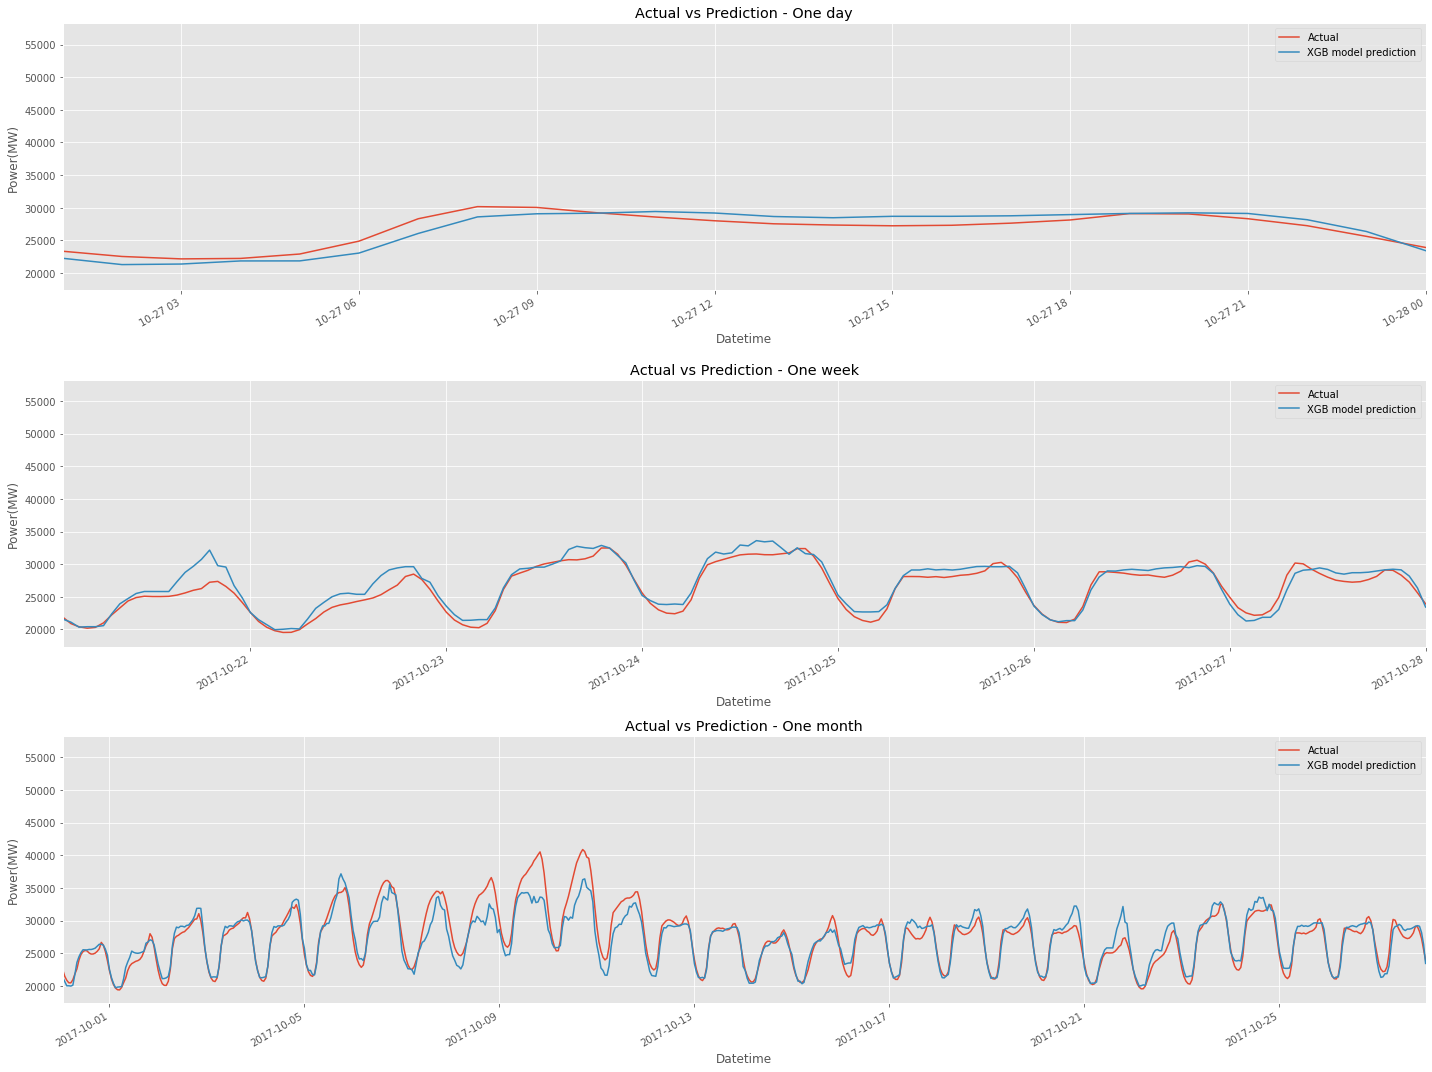

In [44]:
subplot_prediction(y_test, prediction,prediction_label='XGB model prediction')